In [1]:
# two

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint

    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9444444444444444, Loss: 0.30688836839463973
Checkpoint 200, Accuracy: 0.9506172839506173, Loss: 0.253175452903465
Checkpoint 300, Accuracy: 0.9629629629629629, Loss: 0.20593978740550853
Checkpoint 400, Accuracy: 0.9691358024691358, Loss: 0.15003372121740272
Checkpoint 500, Accuracy: 0.9629629629629629, Loss: 0.14833602198848017


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.9793458  0.0137935  0.00686068]
[0. 0. 1.] <-> [1.6876156e-02 6.5254699e-04 9.8247129e-01]
[0. 1. 0.] <-> [4.5475334e-02 9.5432287e-01 2.0181830e-04]
[1. 0. 0.] <-> [0.95135736 0.0462621  0.00238044]
[1. 0. 0.] <-> [0.9602035  0.03386439 0.00593208]
[0. 0. 1.] <-> [1.6930912e-02 6.5378705e-04 9.8241526e-01]
[1. 0. 0.] <-> [0.9784192  0.0120927  0.00948821]
[1. 0. 0.] <-> [0.97404593 0.01795609 0.00799802]
[1. 0. 0.] <-> [0.9771453  0.01367993 0.00917471]
[1. 0. 0.] <-> [0.9753112  0.01969977 0.00498893]
[0. 0. 1.] <-> [1.6881302e-02 6.5659033e-04 9.8246205e-01]
[0. 0. 1.] <-> [1.7267702e-02 6.8885164e-04 9.8204345e-01]
[1. 0. 0.] <-> [0.97812647 0.01752261 0.00435105]
[1. 0. 0.] <-> [0.977998   0.01468869 0.00731324]
[0. 0. 1.] <-> [1.6871016e-02 6.5243169e-04 9.8247659e-01]
[0. 0. 1.] <-> [1.6914666e-02 6.5620220e-04 9.8242915e-01]
[1. 0. 0.] <-> [0.96119475 0.01634639 0.02245892]
[0. 0. 1.] <-> [0.6907809  0.01374081 0.2954783 ]
[0. 0. 1.] <-> [1.6962875e-02 6.55017

In [12]:
# Testing Performance

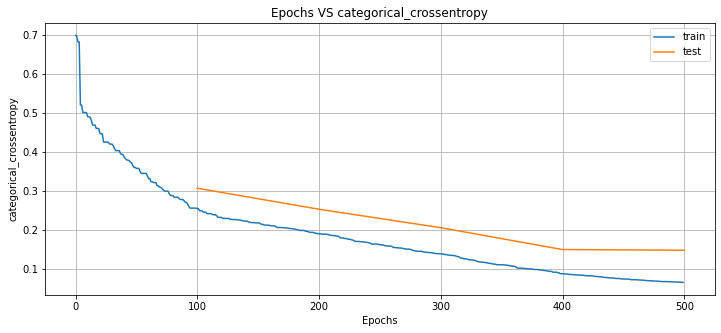

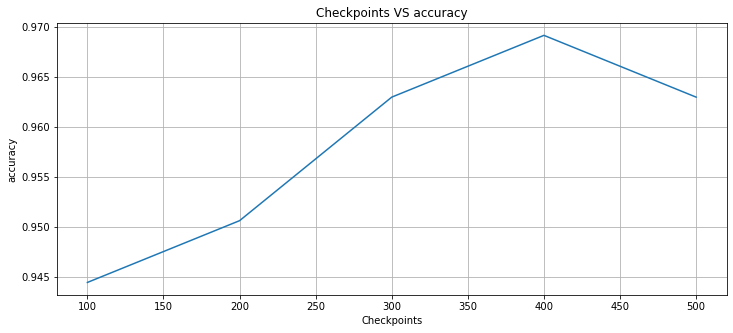

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9444444444444444, 'mean_square_error': 0.14796805832912502, 'categorical_crossentropy': 0.30688836839463973, 'precision': 0.9166666666666666, 'recall': 0.9166666666666666, 'f1': 0.9166666666666666, 'essential_metrics': {0: {'tp_hit': 74, 'fp_hit': 7, 'tn_hit': 25, 'fn_hit': 2}, 1: {'tp_hit': 13, 'fp_hit': 2, 'tn_hit': 89, 'fn_hit': 4}, 2: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 3}}, 'checkpoint': 100} 


{'accuracy': 0.9506172839506173, 'mean_square_error': 0.12225550287139002, 'categorical_crossentropy': 0.253175452903465, 'precision': 0.9259259259259259, 'recall': 0.9259259259259259, 'f1': 0.9259259259259259, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 7, 'tn_hit': 25, 'fn_hit': 1}, 1: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 90, 'fn_hit': 4}, 2: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 3}}, 'checkpoint': 200} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.0968932265050535, 'categorical_crossentropy': 0.20593978740550853, 'precisio

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[ 1.720806  -1.9866946 -1.3338454  2.0295317  0.6408779]
 bias: -3.0

Neuron 1: weights:
[-2.9287472  0.2000843  2.872138  -2.5709906  0.6180374]
 bias: -1.5217032432556152

Neuron 2: weights:
[-1.2605982  3.         3.         1.1905855 -1.3153154]
 bias: -2.988389492034912

Neuron 3: weights:
[ 0.9982404 -3.        -1.1640925  2.8104239  0.9747339]
 bias: -2.8453333377838135

$
Layer 2
Neuron 0: weights:
[-1.6953212   0.72076297 -3.         -1.8143278 ]
 bias: 3.0

Neuron 1: weights:
[ 0.8021711  2.3518918  3.        -2.9771597]
 bias: -1.5872912406921387

Neuron 2: weights:
[ 2.8842785  -0.41554973 -1.9518571   3.        ]
 bias: -2.329393148422241

$

